In [15]:
"""
Dataset Generation for Tau Protein Misfolding Prediction

This notebook:
1. Loads tau protein sequences from FASTA file
2. Creates or loads labels
3. Validates data quality
4. Saves processed datasets
"""

import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Import ONLY dataset-related utilities
from utils.dataset import (
    load_fasta,
    save_fasta,
)

from utils.dataset import (
    create_synthetic_labels,
    load_labels,
    validate_sequences,
    save_core_tables,
)

from utils.config import (
    FASTA_FILE,
    SEQUENCES_CSV,
    LABELS_CSV,
    PROCESSED_DATA_DIR,
)

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ All imports successful!")



✅ All imports successful!


In [16]:
"""
Load tau protein sequences from FASTA file
"""

print("=" * 80)
print("STEP 1: LOADING FASTA FILE")
print("=" * 80)

# Check if FASTA file exists
if not FASTA_FILE.exists():
    print(f"⚠️  FASTA file not found: {FASTA_FILE}")
    print("Creating example FASTA file for demonstration...")
    
    # Create example sequences (replace with real data)
    example_sequences = pd.DataFrame({
        'protein_id': [f'TAU_{i:04d}' for i in range(100)],
        'description': ['Tau protein example'] * 100,
        'sequence': ['MAEPRQEFEVMEDHAGTYGLGDRKDQGGYTMHQDQEGDTDAGLKESPLQTP'] * 100,
        'length': [52] * 100,
        'species': ['Homo sapiens'] * 50 + ['Mus musculus'] * 50,
    })
    
    # Save example FASTA
    FASTA_FILE.parent.mkdir(parents=True, exist_ok=True)
    save_fasta(example_sequences, FASTA_FILE)
    print(f"✅ Created example FASTA: {FASTA_FILE}")

# Load FASTA
df_sequences = load_fasta(FASTA_FILE)

print(f"\n📊 Loaded {len(df_sequences)} sequences")
print(f"Columns: {df_sequences.columns.tolist()}")


2025-12-18 06:39:37,697 - utils.dataset - INFO - Loading FASTA file: /workspaces/Alzheimer-s-Biomarker/tau_stacking_project/data/raw/tau_all_species.fasta
2025-12-18 06:39:37,704 - utils.dataset - INFO - Loaded 203 sequences from 47 species
2025-12-18 06:39:37,706 - utils.dataset - INFO - Sequence length range: 14 - 2282


STEP 1: LOADING FASTA FILE

📊 Loaded 203 sequences
Columns: ['protein_id', 'description', 'sequence', 'length', 'species']


STEP 2: DATA EXPLORATION

📋 First 5 sequences:
   protein_id                                        description  \
0  A0A0N7CSQ4  sp|A0A0N7CSQ4|TX41A_SCOMU Tau-scoloptoxin(04)-...   
1  A0A5F8MPU3  sp|A0A5F8MPU3|CTSRT_MOUSE Cation channel sperm...   
2      O02828  sp|O02828|TAU_CAPHI Microtubule-associated pro...   
3      P06710  sp|P06710|DPO3X_ECOLI DNA polymerase III subun...   
4      P10636  sp|P10636|TAU_HUMAN Microtubule-associated pro...   

                                            sequence  length  \
0  MLKSFCILSVFMVLFLAKFPDLCSGEEISPLKIVVRNSEYLNNPCN...      68   
1  MELPPPGNRRVSINNPQETSGRVPTTSAGFPTQSSKISLKRSTYAY...    2282   
2  MAEPRQEFDVMEDHAQGDYTLQDHEGDMEPGLKESPLQTPADDGSE...     403   
3  MSYQVLARKWRPQTFADVVGQEHVLTALANGLSLGRIHHAYLFSGT...     643   
4  MAEPRQEFEVMEDHAGTYGLGDRKDQGGYTMHQDQEGDTDAGLKES...     758   

                         species  
0           Scolopendra mutilans  
1                   Mus musculus  
2                   Capra hircus  
3  Escherichia coli

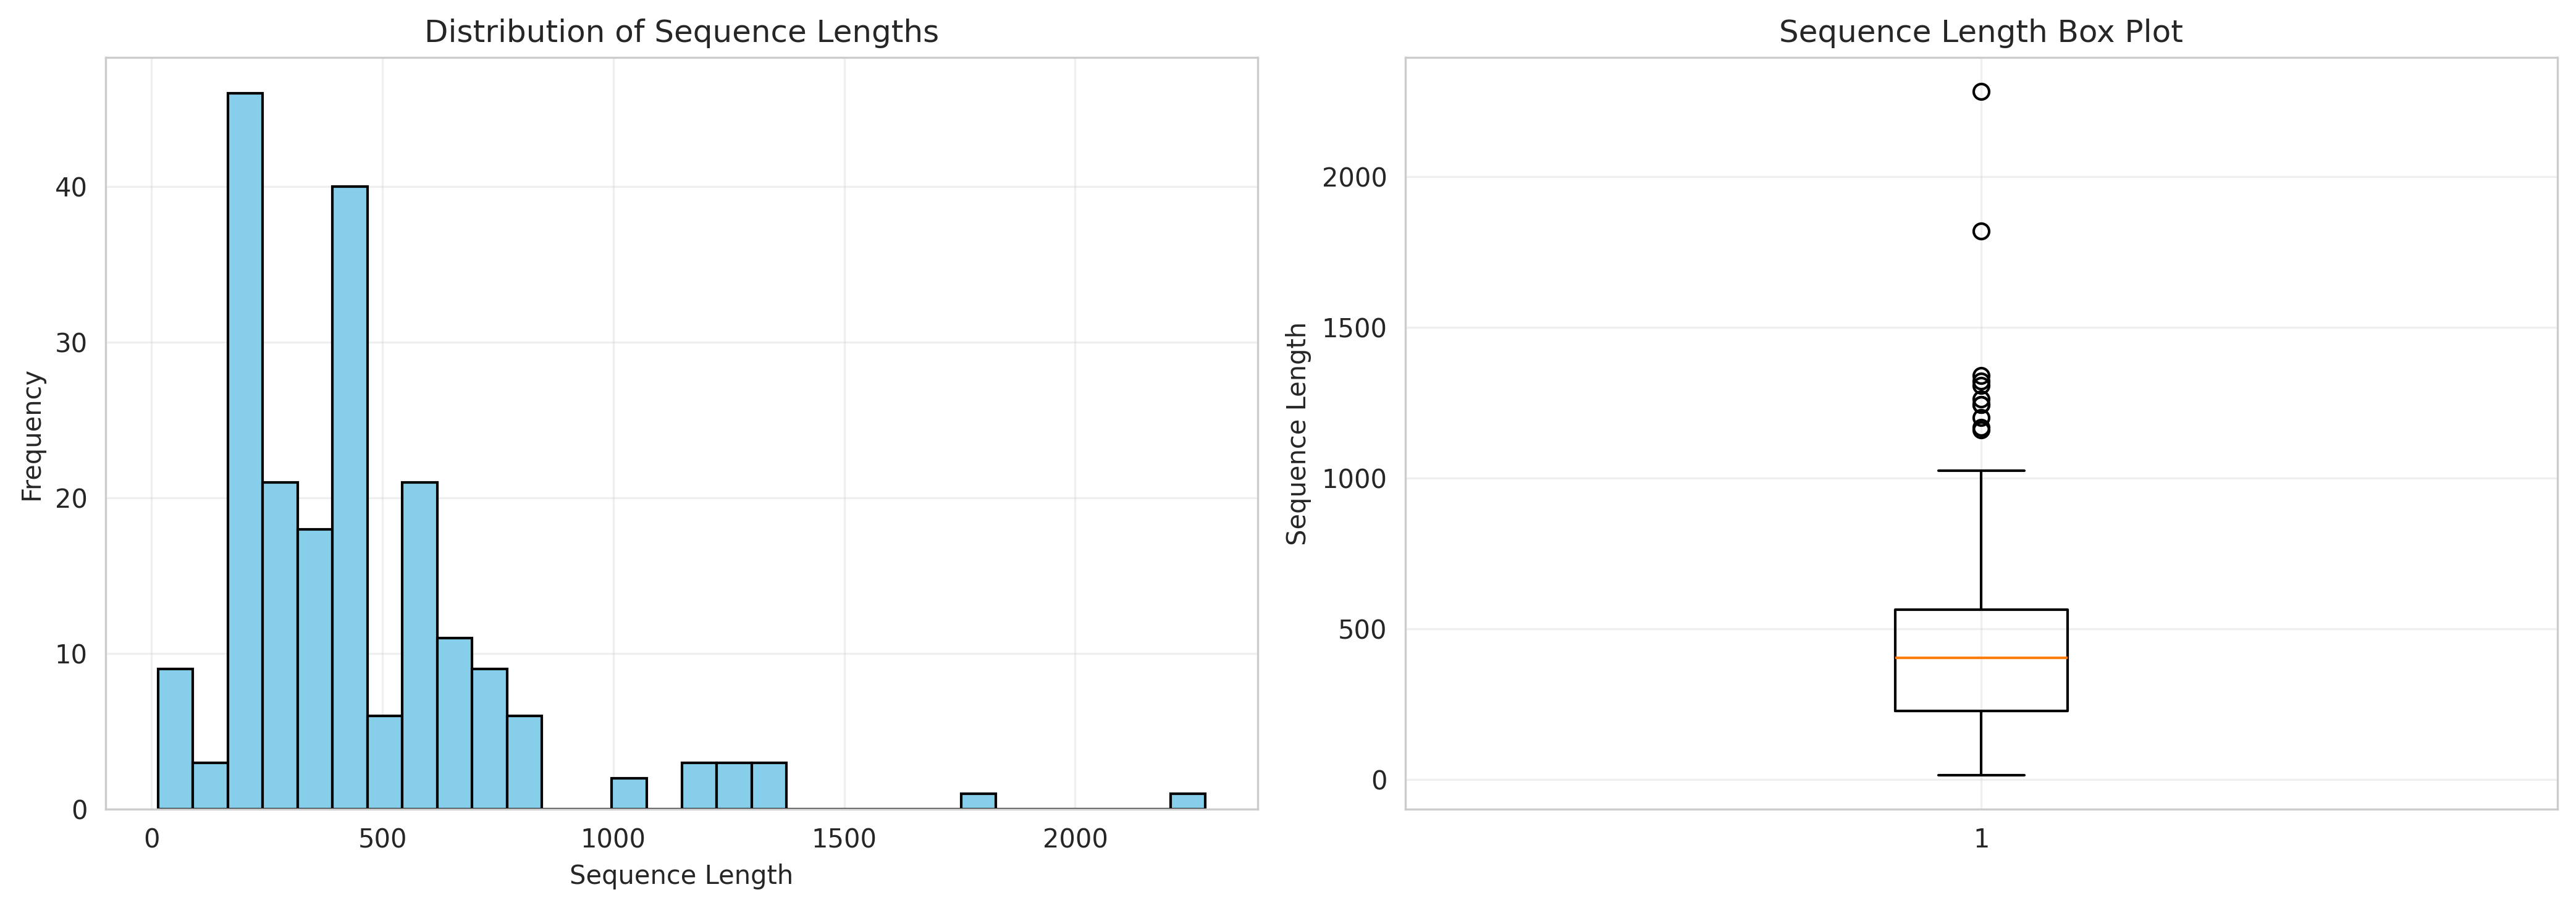


✅ Sequence length range: 14 - 2282


In [17]:
"""
Explore the loaded sequences
"""

print("=" * 80)
print("STEP 2: DATA EXPLORATION")
print("=" * 80)

# Display first few sequences
print("\n📋 First 5 sequences:")
print(df_sequences.head())

# Basic statistics
print("\n📊 Sequence length statistics:")
print(df_sequences['length'].describe())

# Species distribution
print("\n🌍 Species distribution:")
print(df_sequences['species'].value_counts())

# Visualize sequence length distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df_sequences['length'], bins=30, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Sequence Length')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Sequence Lengths')
axes[0].grid(alpha=0.3)

# Box plot
axes[1].boxplot(df_sequences['length'])
axes[1].set_ylabel('Sequence Length')
axes[1].set_title('Sequence Length Box Plot')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✅ Sequence length range: {df_sequences['length'].min()} - {df_sequences['length'].max()}")


2025-12-18 06:39:38,315 - utils.dataset - WARNING - Found 4 validation errors


STEP 3: SEQUENCE VALIDATION
⚠️  Found 4 validation errors:
  1. Q09136: Invalid amino acids: {'X'}
  2. P81123: Invalid amino acids: {'X'}
  3. Q5S6V2: Invalid amino acids: {'X'}
  4. Q5YCV9: Invalid amino acids: {'X'}

🔬 Checking amino acid composition...
Unique characters found: ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'X', 'Y']
⚠️  Invalid characters: {'X'}


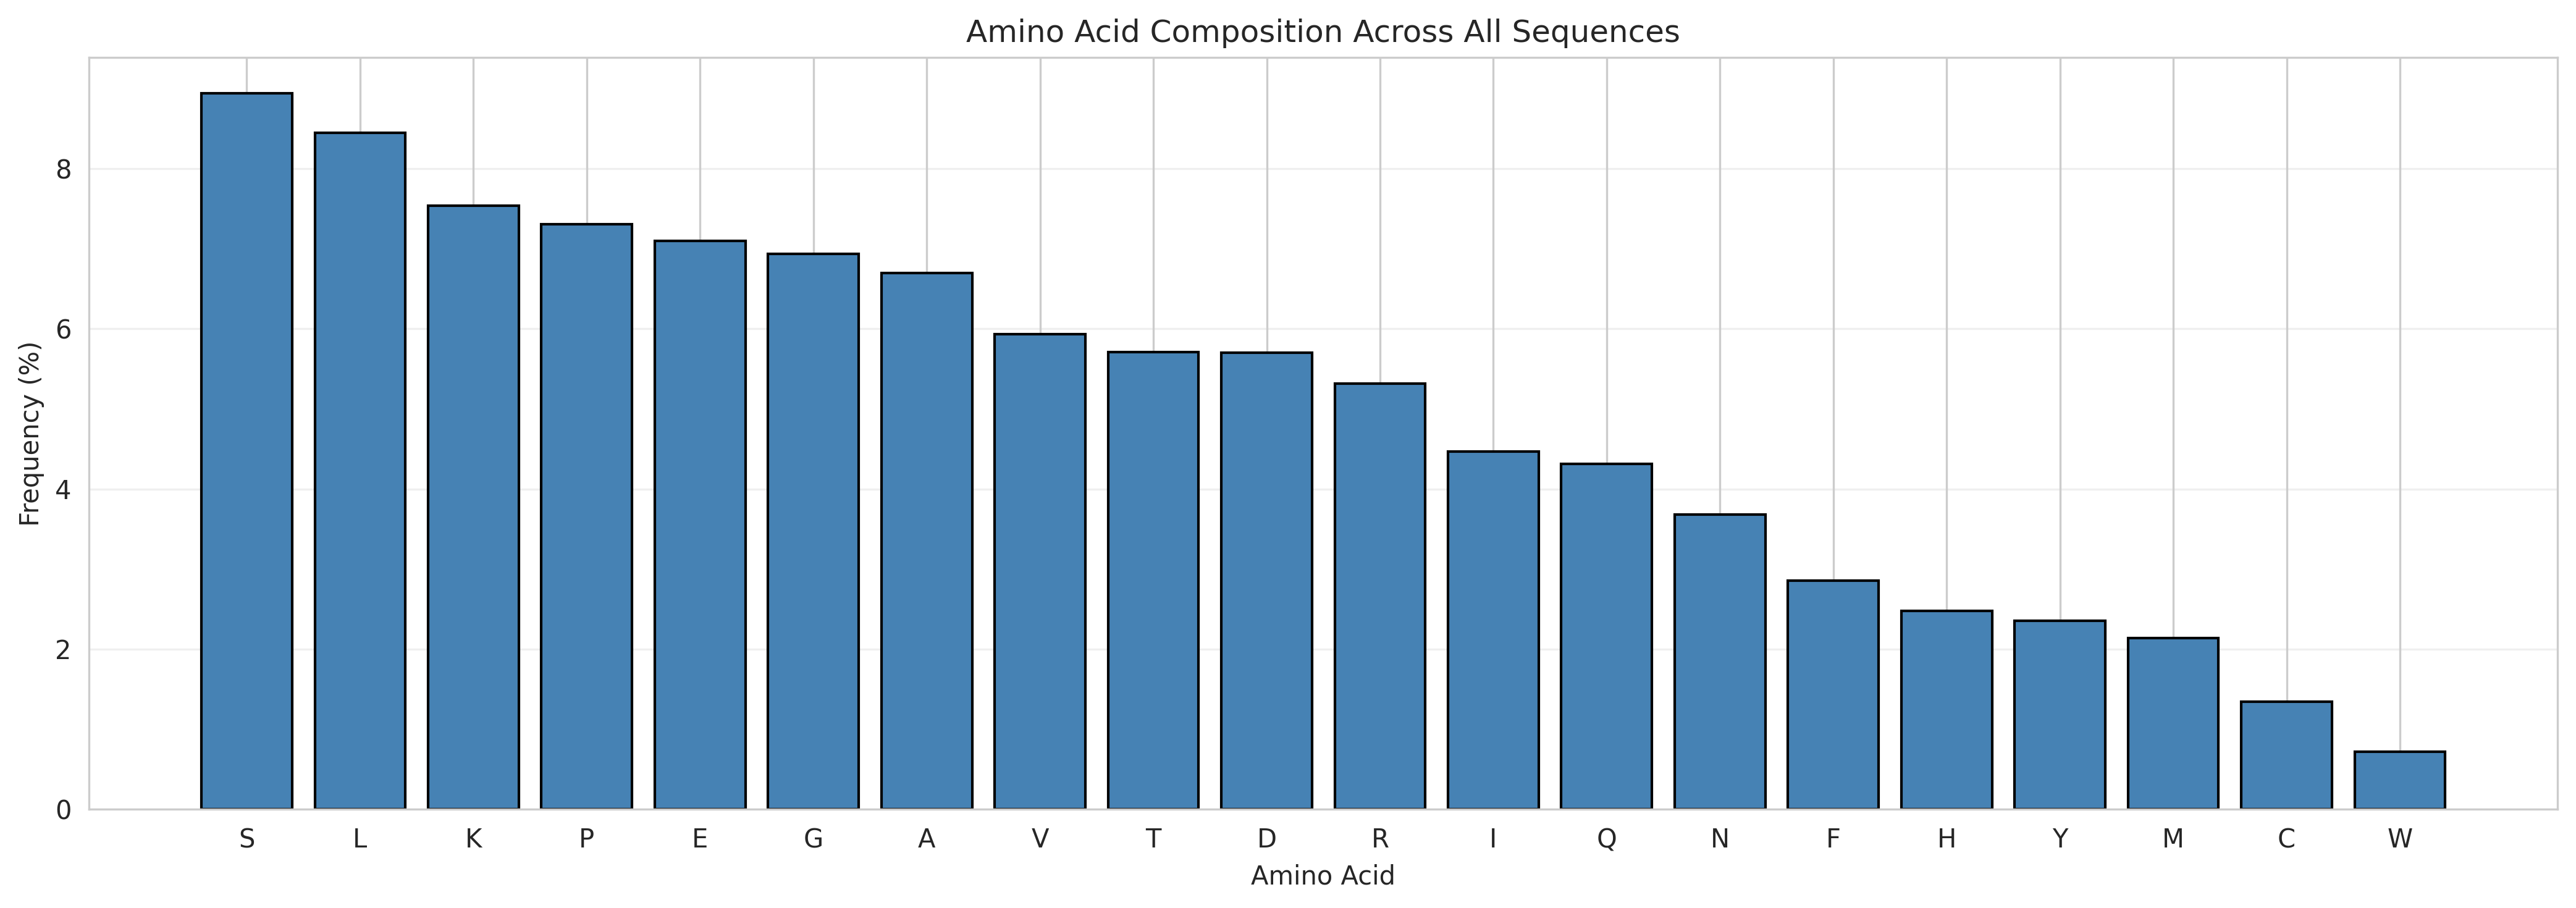

In [18]:
"""
Validate protein sequences for quality
"""

print("=" * 80)
print("STEP 3: SEQUENCE VALIDATION")
print("=" * 80)

# Validate sequences
is_valid, errors = validate_sequences(df_sequences, sequence_column='sequence')

if is_valid:
    print("✅ All sequences are valid!")
else:
    print(f"⚠️  Found {len(errors)} validation errors:")
    for i, error in enumerate(errors[:10]):  # Show first 10 errors
        print(f"  {i+1}. {error}")
    
    if len(errors) > 10:
        print(f"  ... and {len(errors) - 10} more errors")

# Check amino acid composition
print("\n🔬 Checking amino acid composition...")
all_amino_acids = ''.join(df_sequences['sequence'].tolist())
unique_chars = set(all_amino_acids)
valid_aa = set('ACDEFGHIKLMNPQRSTVWY')

print(f"Unique characters found: {sorted(unique_chars)}")
invalid_chars = unique_chars - valid_aa
if invalid_chars:
    print(f"⚠️  Invalid characters: {invalid_chars}")
else:
    print("✅ All characters are valid amino acids")

# Calculate amino acid frequency
aa_counts = {aa: all_amino_acids.count(aa) for aa in valid_aa}
total_aa = sum(aa_counts.values())
aa_freq = {aa: count/total_aa*100 for aa, count in aa_counts.items()}

# Plot amino acid frequency
plt.figure(figsize=(14, 5))
sorted_aa = sorted(aa_freq.items(), key=lambda x: x[1], reverse=True)
aas, freqs = zip(*sorted_aa)

plt.bar(aas, freqs, color='steelblue', edgecolor='black')
plt.xlabel('Amino Acid')
plt.ylabel('Frequency (%)')
plt.title('Amino Acid Composition Across All Sequences')
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


2025-12-18 06:39:38,806 - utils.dataset - WARNING - Creating SYNTHETIC labels - replace with real labels for research!
2025-12-18 06:39:38,808 - utils.dataset - INFO - Created 203 synthetic labels
2025-12-18 06:39:38,813 - utils.dataset - INFO - Label distribution: {0: 143, 1: 60}


STEP 4: LABELS
⚠️  Labels file not found. Creating synthetic labels for demonstration...
❗ IMPORTANT: Replace with real labels for actual research!
✅ Saved synthetic labels to: /workspaces/Alzheimer-s-Biomarker/tau_stacking_project/data/processed/labels.csv

📊 Label statistics:
   protein_id  label     source
0  A0A0N7CSQ4      1  synthetic
1  A0A5F8MPU3      1  synthetic
2      O02828      0  synthetic
3      P06710      0  synthetic
4      P10636      0  synthetic

Total labels: 203

Label distribution:
label
0    143
1     60
Name: count, dtype: int64

Label proportions:
label
0    0.704433
1    0.295567
Name: proportion, dtype: float64


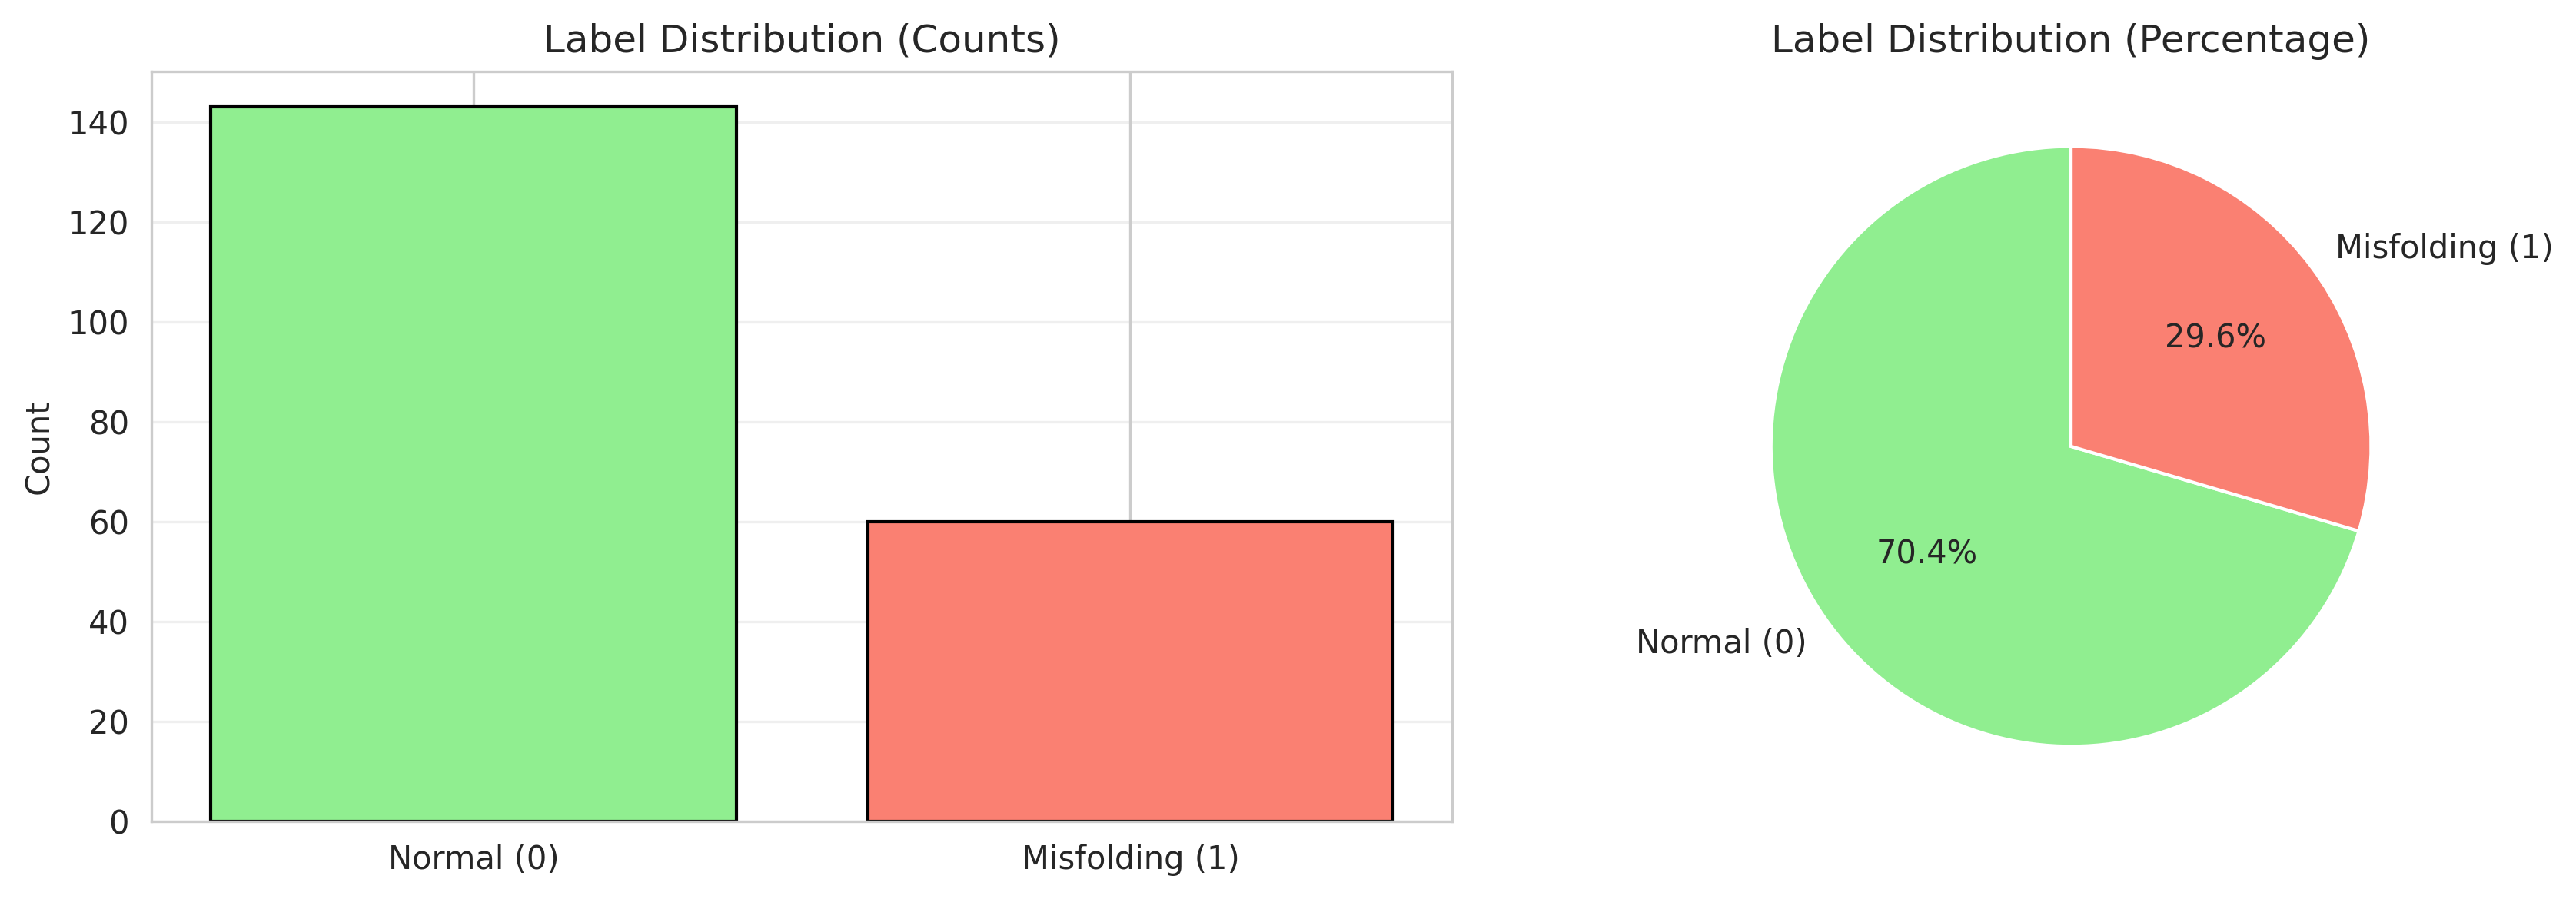

In [19]:
"""
Create or load labels for sequences
"""

print("=" * 80)
print("STEP 4: LABELS")
print("=" * 80)

# Check if labels file exists
if LABELS_CSV.exists():
    print(f"Loading existing labels from: {LABELS_CSV}")
    df_labels = load_labels(LABELS_CSV)
else:
    print("⚠️  Labels file not found. Creating synthetic labels for demonstration...")
    print("❗ IMPORTANT: Replace with real labels for actual research!")
    
    # Create synthetic labels
    df_labels = create_synthetic_labels(df_sequences, positive_ratio=0.3)
    
    # Save synthetic labels
    LABELS_CSV.parent.mkdir(parents=True, exist_ok=True)
    df_labels.to_csv(LABELS_CSV, index=False)
    print(f"✅ Saved synthetic labels to: {LABELS_CSV}")

# Display label statistics
print(f"\n📊 Label statistics:")
print(df_labels.head())
print(f"\nTotal labels: {len(df_labels)}")
print(f"\nLabel distribution:")
print(df_labels['label'].value_counts())
print(f"\nLabel proportions:")
print(df_labels['label'].value_counts(normalize=True))

# Visualize label distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Count plot
label_counts = df_labels['label'].value_counts()
axes[0].bar(['Normal (0)', 'Misfolding (1)'], 
            [label_counts[0], label_counts[1]], 
            color=['lightgreen', 'salmon'],
            edgecolor='black')
axes[0].set_ylabel('Count')
axes[0].set_title('Label Distribution (Counts)')
axes[0].grid(alpha=0.3, axis='y')

# Pie chart
axes[1].pie([label_counts[0], label_counts[1]], 
            labels=['Normal (0)', 'Misfolding (1)'],
            colors=['lightgreen', 'salmon'],
            autopct='%1.1f%%',
            startangle=90)
axes[1].set_title('Label Distribution (Percentage)')

plt.tight_layout()
plt.show()


STEP 5: MERGE SEQUENCES AND LABELS
📊 Merged dataset:
  Total samples: 203
  Features: ['protein_id', 'description', 'sequence', 'length', 'species', 'label', 'source']

🔍 Missing values:
protein_id     0
description    0
sequence       0
length         0
species        0
label          0
source         0
dtype: int64

📋 First 5 rows of merged data:
   protein_id                                        description  \
0  A0A0N7CSQ4  sp|A0A0N7CSQ4|TX41A_SCOMU Tau-scoloptoxin(04)-...   
1  A0A5F8MPU3  sp|A0A5F8MPU3|CTSRT_MOUSE Cation channel sperm...   
2      O02828  sp|O02828|TAU_CAPHI Microtubule-associated pro...   
3      P06710  sp|P06710|DPO3X_ECOLI DNA polymerase III subun...   
4      P10636  sp|P10636|TAU_HUMAN Microtubule-associated pro...   

                                            sequence  length  \
0  MLKSFCILSVFMVLFLAKFPDLCSGEEISPLKIVVRNSEYLNNPCN...      68   
1  MELPPPGNRRVSINNPQETSGRVPTTSAGFPTQSSKISLKRSTYAY...    2282   
2  MAEPRQEFDVMEDHAQGDYTLQDHEGDMEPGLKESPLQTPADDGS

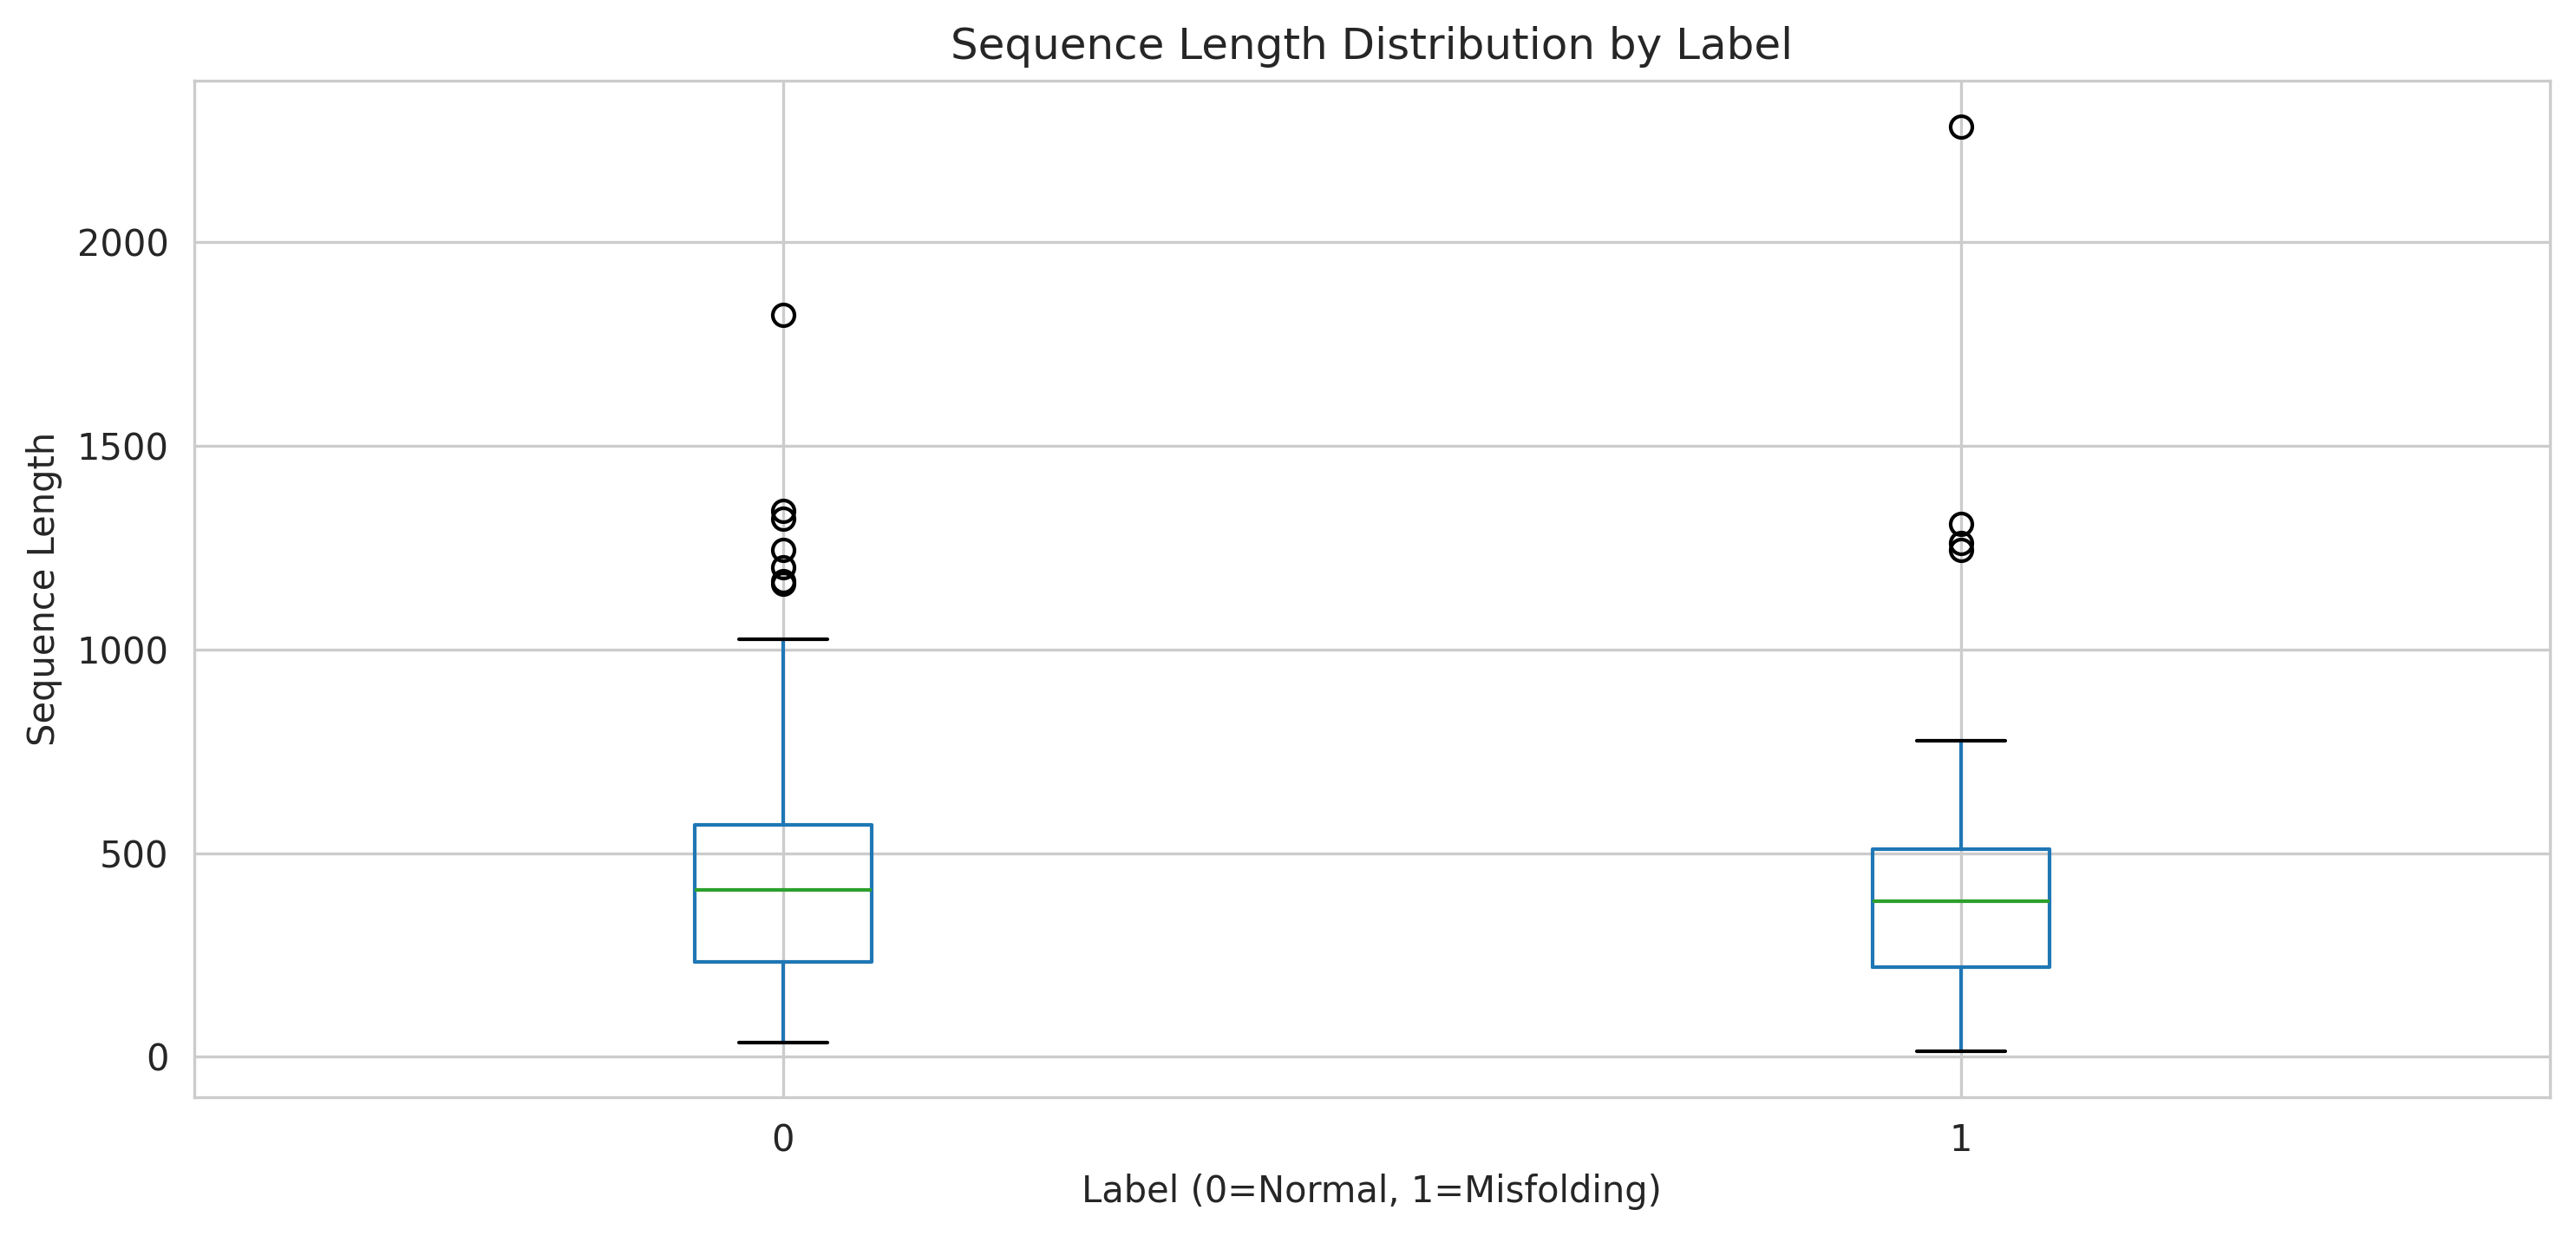

In [20]:
"""
Merge sequences with labels
"""

print("=" * 80)
print("STEP 5: MERGE SEQUENCES AND LABELS")
print("=" * 80)

# Merge dataframes
df_merged = df_sequences.merge(df_labels, on='protein_id', how='inner')

print(f"📊 Merged dataset:")
print(f"  Total samples: {len(df_merged)}")
print(f"  Features: {df_merged.columns.tolist()}")

# Check for missing values
print(f"\n🔍 Missing values:")
print(df_merged.isnull().sum())

# Display merged data
print(f"\n📋 First 5 rows of merged data:")
print(df_merged.head())

# Analyze sequence length by label
print(f"\n📏 Sequence length by label:")
print(df_merged.groupby('label')['length'].describe())

# Visualize
fig, ax = plt.subplots(figsize=(10, 5))
df_merged.boxplot(column='length', by='label', ax=ax)
ax.set_xlabel('Label (0=Normal, 1=Misfolding)')
ax.set_ylabel('Sequence Length')
ax.set_title('Sequence Length Distribution by Label')
plt.suptitle('')  # Remove default title
plt.tight_layout()
plt.show()


In [21]:
"""
Save processed sequences and labels
"""

print("=" * 80)
print("STEP 6: SAVE PROCESSED DATA")
print("=" * 80)

# Prepare data for saving
df_sequences_final = df_merged[['protein_id', 'description', 'sequence', 'length', 'species']]
df_labels_final = df_merged[['protein_id', 'label', 'source']]

# Create dummy splits table (will be properly split in next notebook)
df_splits_temp = pd.DataFrame({
    'protein_id': df_merged['protein_id'],
    'split': 'none'  # Placeholder
})

# Save
PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)

df_sequences_final.to_csv(SEQUENCES_CSV, index=False)
df_labels_final.to_csv(LABELS_CSV, index=False)

print(f"✅ Saved sequences to: {SEQUENCES_CSV}")
print(f"✅ Saved labels to: {LABELS_CSV}")

print(f"\n📊 Summary:")
print(f"  Total sequences: {len(df_sequences_final)}")
print(f"  Total labels: {len(df_labels_final)}")
print(f"  Sequence length: {df_sequences_final['length'].min()} - {df_sequences_final['length'].max()}")
print(f"  Label 0 (Normal): {(df_labels_final['label']==0).sum()}")
print(f"  Label 1 (Misfolding): {(df_labels_final['label']==1).sum()}")


STEP 6: SAVE PROCESSED DATA
✅ Saved sequences to: /workspaces/Alzheimer-s-Biomarker/tau_stacking_project/data/processed/sequences.csv
✅ Saved labels to: /workspaces/Alzheimer-s-Biomarker/tau_stacking_project/data/processed/labels.csv

📊 Summary:
  Total sequences: 203
  Total labels: 203
  Sequence length: 14 - 2282
  Label 0 (Normal): 143
  Label 1 (Misfolding): 60


In [22]:
"""
Summary and next steps
"""

print("=" * 80)
print("✅ DATASET GENERATION COMPLETE!")
print("=" * 80)

print("\n📋 Generated Files:")
print(f"  1. {SEQUENCES_CSV}")
print(f"  2. {LABELS_CSV}")

print("\n📊 Dataset Statistics:")
print(f"  Total samples: {len(df_merged)}")
print(f"  Features: {len(df_merged.columns)}")
print(f"  Avg sequence length: {df_merged['length'].mean():.1f}")
print(f"  Class balance: {(df_merged['label']==1).mean()*100:.1f}% positive")

print("\n🎯 Next Steps:")
print("  → Run notebook 02_preprocessing.ipynb to:")
print("     - Create train/val/test splits")
print("     - Generate embeddings")
print("     - Encode sequences")

print("\n" + "=" * 80)


✅ DATASET GENERATION COMPLETE!

📋 Generated Files:
  1. /workspaces/Alzheimer-s-Biomarker/tau_stacking_project/data/processed/sequences.csv
  2. /workspaces/Alzheimer-s-Biomarker/tau_stacking_project/data/processed/labels.csv

📊 Dataset Statistics:
  Total samples: 203
  Features: 7
  Avg sequence length: 447.5
  Class balance: 29.6% positive

🎯 Next Steps:
  → Run notebook 02_preprocessing.ipynb to:
     - Create train/val/test splits
     - Generate embeddings
     - Encode sequences

